# Import requirements

In [ ]:
import time
import os
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from torchinfo import summary
from fvcore.nn import FlopCountAnalysis

current_dir = os.path.basename(os.getcwd())

if current_dir != "yolov5":
    if os.path.isdir("yolov5"):
        os.chdir("yolov5")

from models.common import DetectMultiBackend
from utils.torch_utils import select_device


ImportError: cannot import name 'logger' from 'fvcore.nn.jit_handles' (/home/dishapant/miniconda3/envs/yolo-benchmark/lib/python3.11/site-packages/fvcore/nn/jit_handles.py)

# Load COCO 128 dataset

In [3]:
data_path  = Path("../datasets/coco128/images/train2017")
image_files = list(data_path.glob("*.jpg"))[:100]
print(f"Total images: {len(image_files)}")

Total images: 100


# Load YOLOv5 models

In [ ]:
device = select_device("cuda" if torch.cuda.is_available() else "cpu")

models  = {
    'yolov5n': DetectMultiBackend('yolov5n.pt', device=device),
    'yolov5s': DetectMultiBackend('yolov5s.pt', device=device),
    'yolov5m': DetectMultiBackend('yolov5m.pt', device=device),
    'yolov5l': DetectMultiBackend('yolov5l.pt', device=device),
    'yolov5x': DetectMultiBackend('yolov5x.pt', device=device),
}

YOLOv5 🚀 v7.0-411-gf4d8a84c Python-3.11.11 torch-2.6.0+cu124 CPU



Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients, 4.5 GFLOPs
Fusing layers... 


cpu


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients, 48.9 GFLOPs
Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients, 109.0 GFLOPs
Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients, 205.5 GFLOPs


# Run Inference and Benchmark Performance

In [45]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((640, 640))
])


latencies = {}
fps_values = {}
gflops_dict = {}
params_dict = {}
utilization_dict = {}
model_size_dict = {}
per_layer_gflops_dict = {}
oi_dict = {}
bound_type_dict = {}
timing_results = []

PEAK_GFLOPS = 410 # GFLOPS
PEAK_BANDWIDTH = 28.1 # GB/s

for model_name, model in models.items():

    model = model.to(device).eval()
    dummy = torch.randn(1, 3, 640, 640).to(device)
    for _ in range(3):
        with torch.no_grad():
            _ = model(dummy)

    total_time = 0

    for img_path in image_files:
        img = Image.open(img_path).convert('RGB')  # Open and convert to RGB
        img = transform(img).unsqueeze(0).to(device)  # Apply transforms, add batch dimension, move to device

        start_time = time.time()
        with torch.no_grad():
            _ = model(img)
        end_time = time.time()

        total_time += (end_time - start_time)

    avg_latency = (total_time / len(image_files)) * 1000  # Convert to ms
    avg_fps = len(image_files) / total_time  # Compute FPS

    latencies[model_name] = avg_latency
    fps_values[model_name] = avg_fps
    timing_results.append((model_name, avg_latency, avg_fps))

    # model parameters
    info = summary(model, input_size=(1, 3, 640, 640), verbose=0)
    total_params = info.total_params
    params_m = total_params / 1e6
    model_size_mb = total_params * 4 / (1024 ** 2)

    params_dict[model_name] = params_m
    model_size_dict[model_name] = model_size_mb

    # FLOPs
    input_tensor = torch.randn(1, 3, 640, 640).to(device)
    flops = FlopCountAnalysis(model, input_tensor)
    total_flops = flops.total()
    gflops = total_flops / 1e9
    gflops_dict[model_name] = gflops


    # Utilization
    actual_gflops_per_second = gflops / (avg_latency / 1000)
    utilization = (actual_gflops_per_second / PEAK_GFLOPS) * 100
    utilization_dict[model_name] = utilization

    # Operational Intensity
    input_size_bytes = 3 * 640 * 640 * 4  # RGB image, float32
    activation_estimate = input_size_bytes * 3
    memory_accessed = total_params * 4 + activation_estimate
    oi = total_flops / memory_accessed
    peak_oi = PEAK_GFLOPS / PEAK_BANDWIDTH

    oi_dict[model_name] = oi
    bound_type = "Compute Bound" if oi > peak_oi else "Memory Bound"
    bound_type_dict[model_name] = bound_type

    # Per-layer GFLOPs
    layer_flops = flops.by_module()
    layer_gflops = {k: v / 1e9 for k, v in layer_flops.items()}
    per_layer_gflops_dict[model_name] = layer_gflops

Unsupported operator aten::silu_ encountered 57 time(s)
Unsupported operator aten::add encountered 10 time(s)
Unsupported operator aten::max_pool2d encountered 3 time(s)
Unsupported operator aten::mul encountered 22 time(s)
Unsupported operator aten::sigmoid encountered 3 time(s)
Unsupported operator aten::pow encountered 3 time(s)
Unsupported operator aten::silu_ encountered 57 time(s)
Unsupported operator aten::add encountered 10 time(s)
Unsupported operator aten::max_pool2d encountered 3 time(s)
Unsupported operator aten::mul encountered 22 time(s)
Unsupported operator aten::sigmoid encountered 3 time(s)
Unsupported operator aten::pow encountered 3 time(s)
Unsupported operator aten::silu_ encountered 79 time(s)
Unsupported operator aten::add encountered 17 time(s)
Unsupported operator aten::max_pool2d encountered 3 time(s)
Unsupported operator aten::mul encountered 22 time(s)
Unsupported operator aten::sigmoid encountered 3 time(s)
Unsupported operator aten::pow encountered 3 time(s

# Benchmarking Results

In [46]:
print("_______________________________________________")
print("Model                  Latency (ms)        FPS")
print("_______________________________________________")
for model_name, latency, fps in timing_results:
    print(f"{model_name:<16} {latency:>14.2f} ms    {fps:>8.2f}")
print("_______________________________________________")

_______________________________________________
Model                  Latency (ms)        FPS
_______________________________________________
yolov5n                   27.37 ms       36.54
yolov5s                   56.33 ms       17.75
yolov5m                  126.00 ms        7.94
yolov5l                  237.89 ms        4.20
yolov5x                  415.73 ms        2.41
_______________________________________________


# Visualization

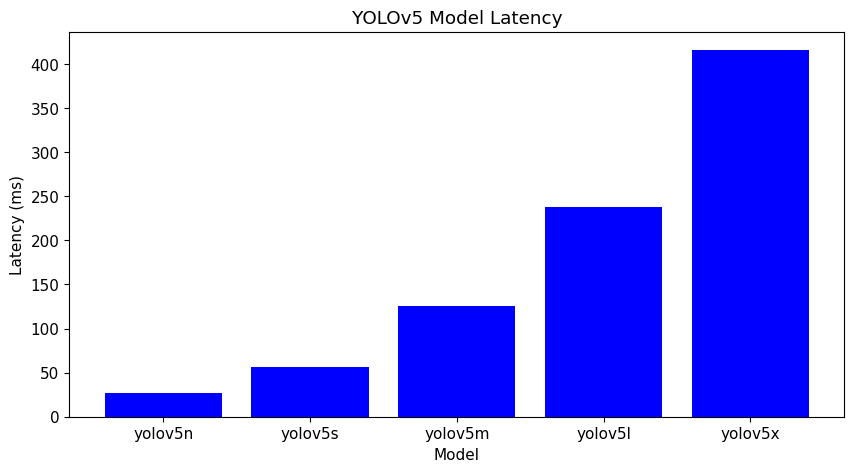

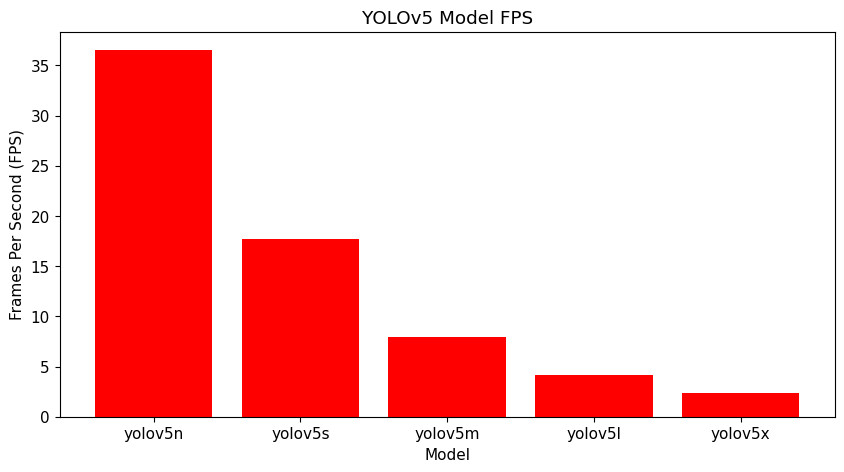

In [47]:
%matplotlib inline

# Plot Latency
plt.figure(figsize=(10, 5))
plt.bar(latencies.keys(), latencies.values(), color='blue')
plt.xlabel('Model')
plt.ylabel('Latency (ms)')
plt.title('YOLOv5 Model Latency')
plt.show()

# Plot FPS
plt.figure(figsize=(10, 5))
plt.bar(fps_values.keys(), fps_values.values(), color='red')
plt.xlabel('Model')
plt.ylabel('Frames Per Second (FPS)')
plt.title('YOLOv5 Model FPS')
plt.show()


# Accuracy Analysis

In [7]:
# For YOLOv5n
!python val.py --weights yolov5n.pt --data coco128.yaml --img 640 --iou 0.65 --task val

val: data=/home/dishapant/Desktop/spp/yolov5_benchmarking_optimization/yolov5/data/coco128.yaml, weights=['yolov5n.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.65, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-411-gf4d8a84c Python-3.11.11 torch-2.6.0+cu124 CPU

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients, 4.5 GFLOPs
val: Scanning /home/dishapant/Desktop/spp/yolov5_benchmarking_optimization/datas
                 Class     Images  Instances          P          R      mAP50   
                   all        128        929      0.629      0.478      0.541       0.35
Speed: 0.9ms pre-process, 41.9ms inference, 4.1ms NMS per image at shape (32, 3, 640, 640)
Results saved to runs/val/exp22


In [8]:
# For YOLOv5s
!python val.py --weights yolov5s.pt --data coco128.yaml --img 640 --iou 0.65 --task val

val: data=/home/dishapant/Desktop/spp/yolov5_benchmarking_optimization/yolov5/data/coco128.yaml, weights=['yolov5s.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.65, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-411-gf4d8a84c Python-3.11.11 torch-2.6.0+cu124 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
val: Scanning /home/dishapant/Desktop/spp/yolov5_benchmarking_optimization/datas
                 Class     Images  Instances          P          R      mAP50   
                   all        128        929      0.691      0.623      0.706       0.48
Speed: 0.9ms pre-process, 81.7ms inference, 2.4ms NMS per image at shape (32, 3, 640, 640)
Results saved to runs/val/exp23


In [9]:
# For YOLOv5m
!python val.py --weights yolov5m.pt --data coco128.yaml --img 640 --iou 0.65 --task val

val: data=/home/dishapant/Desktop/spp/yolov5_benchmarking_optimization/yolov5/data/coco128.yaml, weights=['yolov5m.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.65, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-411-gf4d8a84c Python-3.11.11 torch-2.6.0+cu124 CPU

Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients, 48.9 GFLOPs
val: Scanning /home/dishapant/Desktop/spp/yolov5_benchmarking_optimization/datas
                 Class     Images  Instances          P          R      mAP50   
                   all        128        929      0.735      0.694      0.773      0.553
Speed: 1.0ms pre-process, 177.7ms inference, 2.0ms NMS per image at shape (32, 3, 640, 640)
Results saved to runs/val/exp24


In [10]:
# For YOLOv5l
!python val.py --weights yolov5l.pt --data coco128.yaml --img 640 --iou 0.65 --task val

val: data=/home/dishapant/Desktop/spp/yolov5_benchmarking_optimization/yolov5/data/coco128.yaml, weights=['yolov5l.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.65, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-411-gf4d8a84c Python-3.11.11 torch-2.6.0+cu124 CPU

Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients, 109.0 GFLOPs
val: Scanning /home/dishapant/Desktop/spp/yolov5_benchmarking_optimization/datas
                 Class     Images  Instances          P          R      mAP50   
                   all        128        929      0.795      0.694      0.811      0.602
Speed: 0.9ms pre-process, 303.7ms inference, 1.7ms NMS per image at shape (32, 3, 640, 640)
Results saved to runs/val/exp25


In [11]:
# For YOLOv5x
!python val.py --weights yolov5x.pt --data coco128.yaml --img 640 --iou 0.65 --task val

val: data=/home/dishapant/Desktop/spp/yolov5_benchmarking_optimization/yolov5/data/coco128.yaml, weights=['yolov5x.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.65, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-411-gf4d8a84c Python-3.11.11 torch-2.6.0+cu124 CPU

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients, 205.5 GFLOPs
val: Scanning /home/dishapant/Desktop/spp/yolov5_benchmarking_optimization/datas
                 Class     Images  Instances          P          R      mAP50   
                   all        128        929      0.773      0.753      0.824       0.63
Speed: 1.1ms pre-process, 483.9ms inference, 1.6ms NMS per image at shape (32, 3, 640, 640)
Results saved to runs/val/exp26


# Roofline Analysis Information

In [48]:
print("\n")
print("===========================================================================")
print("Model      Params (M)  Size (MB)   GFLOPs   Utilization (%)   Bound Type")
print("===========================================================================")

for model_name in models.keys():
    params_m = params_dict[model_name]
    model_size = model_size_dict[model_name]
    gflops = gflops_dict[model_name]
    utilization = utilization_dict[model_name]
    bound_type = bound_type_dict[model_name]

    print(f"{model_name:<10} {params_m:>10.2f}  {model_size:>9.2f}  {gflops:>7.2f}  "
          f"{utilization:>15.2f}     {bound_type}")

print("===========================================================================")




Model      Params (M)  Size (MB)   GFLOPs   Utilization (%)   Bound Type
yolov5n          1.87       7.12     2.23            19.91     Compute Bound
yolov5s          7.23      27.56     8.22            35.58     Compute Bound
yolov5m         21.17      80.77    24.44            47.31     Compute Bound
yolov5l         46.53     177.51    54.50            55.88     Compute Bound
yolov5x         86.71     330.75   102.73            60.27     Compute Bound


# Per-Layer Analysis

In [49]:
per_layer_utilization_dict = {}
highest_util_layers = {}
lowest_util_layers = {}

for model_name in models.keys():
    model_util = utilization_dict[model_name]
    model_total_gflops = gflops_dict[model_name]
    per_layer_gflops = per_layer_gflops_dict[model_name]

    # Compute per-layer utilization approx.
    per_layer_util = {}
    for layer, layer_gflops in per_layer_gflops.items():
        if layer.strip() == "" or layer.strip() in {"model", "model.model"}:
            continue  # Skip root / aggregate layers
        layer_util = (layer_gflops / model_total_gflops) * model_util
        per_layer_util[layer] = layer_util

    per_layer_utilization_dict[model_name] = per_layer_util

    # Sort layers
    sorted_layers = sorted(per_layer_util.items(), key=lambda x: x[1], reverse=True)

    # Save top and bottom 3 layers
    highest_util_layers[model_name] = sorted_layers[:3]
    lowest_util_layers[model_name] = sorted_layers[-3:]


In [50]:
print("\n===================================================================")
print("Per-Layer Utilization Summary")
print("===================================================================")

for model_name in models.keys():
    print(f"\n🔍 Model: {model_name}")

    print("Highest Utilization Layers:")
    for layer, util in highest_util_layers[model_name]:
        print(f"    {layer:<40}: {util:.2f}%")

    print("Lowest Utilization Layers:")
    for layer, util in lowest_util_layers[model_name]:
        print(f"    {layer:<40}: {util:.2f}%")
print("===================================================================")


Per-Layer Utilization Summary

🔍 Model: yolov5n
Highest Utilization Layers:
    model.model.6                           : 2.22%
    model.model.6.m                         : 1.75%
    model.model.4                           : 1.64%
Lowest Utilization Layers:
    model.model.23.cv3.act                  : 0.00%
    model.model.23.m.0.cv1.act              : 0.00%
    model.model.23.m.0.cv2.act              : 0.00%

🔍 Model: yolov5s
Highest Utilization Layers:
    model.model.6                           : 4.31%
    model.model.6.m                         : 3.41%
    model.model.4                           : 3.18%
Lowest Utilization Layers:
    model.model.23.cv3.act                  : 0.00%
    model.model.23.m.0.cv1.act              : 0.00%
    model.model.23.m.0.cv2.act              : 0.00%

🔍 Model: yolov5m
Highest Utilization Layers:
    model.model.6                           : 7.76%
    model.model.6.m                         : 6.85%
    model.model.4                           : 5.4